In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import RegressorMixin, TransformerMixin
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet, ElasticNetCV

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate, KFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit


In [4]:
# Import custom classes
from supervised_model_pipeline import EdaToolbox, RegressorMultiModelEvaluator

## Inspect the data

In [5]:
# Load the training data
denver_file_path = '../Data/Clean/combined/Denver_combined.csv'
train_full_df = pd.read_csv(denver_file_path)
train_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,245069.0,4305.0,9.275848e+08,239786.727396,243635.279120,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,1259.0,1.0,2434.5429,91.688128,49.747029,"DENVER, CO"
1,2008-05-31,242919.0,4779.0,1.043794e+09,240755.620219,242719.130794,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,1256.8,-1.0,2434.5429,91.688128,49.747029,"DENVER, CO"
2,2008-06-30,245529.0,4789.0,1.136320e+09,241296.223700,241952.165191,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,1258.2,-0.6,2434.5429,91.688128,49.747029,"DENVER, CO"
3,2008-07-31,247607.0,4922.0,1.195890e+09,240843.494803,240801.464621,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,1256.1,-1.0,2434.5429,91.688128,49.747029,"DENVER, CO"
4,2008-08-31,246384.0,4333.0,1.154412e+09,239424.931087,239672.270501,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,1256.2,-0.2,2434.5429,91.688128,49.747029,"DENVER, CO"


In [6]:
# Remove columns that are too predictive
cols_to_remove = ['HomeValueIndexSmSa', 'HomeValueIndex']
train_full_df = train_full_df.drop(cols_to_remove, axis=1)

## Create an EdaToolbox object

In [74]:
# Initialize the EdaToolbox
target_col = 'MeanSalePrice'
eda = EdaToolbox(train_full_df, target_column=target_col)

In [75]:
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,1.000000,"DENVER, CO",1,0,0.0,"Index(['DENVER, CO'], dtype='object', name='Ci..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,1.000000,2434.5429,1,0,0.0,"Index([2434.5429], dtype='float64', name='Peop..."
PctHighSchoolDiploma_2019,float64,1.000000,91.688128,1,0,0.0,"Index([91.688128], dtype='float64', name='PctH..."
PctBachelorsDegree_2019,float64,1.000000,49.747029,1,0,0.0,"Index([49.747029], dtype='float64', name='PctB..."


In [76]:
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## First check the distribution of the target column and select an appropriate target column transformer

In [77]:
# It is not normally distributed. It has a long tail to the right. Need to try different target transformations
target_transformation_dict: dict[str, TransformerMixin] = {
    'StandardScaler': StandardScaler(),
    'PowerTransformer': PowerTransformer(standardize=False),
    'QuantileTransformer': QuantileTransformer(output_distribution='normal', n_quantiles=500, random_state=42),
}

In [78]:
# Create a dict of models for preliminary testing of target transformations
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'Lasso Regression': Lasso(alpha=1.0, random_state=42),
    'ElasticNet Regression': ElasticNet(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(np.logspace(-6, 6, 25)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}


In [79]:
kf_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [80]:
# Use basic ordinal feature transformer
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

In [81]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.102294,0.101943,1.001399,0.659355,0.106030,0.099204,0.101047,0.046733
PowerTransformer,0.000144,0.000160,0.002421,0.002421,0.000152,0.000152,0.000144,0.000110
QuantileTransformer,0.360410,0.346947,1.063085,0.728569,0.330695,0.330933,0.349981,0.306000


In [82]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.102488,0.098333,0.987266,0.653573,0.103120,0.099920,0.099681,0.039813
PowerTransformer,0.000152,0.000161,0.002355,0.002355,0.000157,0.000157,0.000151,0.000101
QuantileTransformer,0.312930,0.252940,1.003459,0.663008,0.167532,0.173911,0.239239,0.212164


In [83]:
# Use basic OHE feature transformer
eda.feature_transformer = eda.get_basic_ohe_feature_transformer()

In [84]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features
model_pred_cv_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict, kf_cv)
model_pred_cv_df

c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.212704,0.212297,1.001399,0.726922,0.349667,0.378371,0.215122,0.115293
PowerTransformer,0.000490,0.000488,0.002421,0.002421,0.000683,0.000683,0.000501,0.000380
QuantileTransformer,0.451849,0.442372,1.095851,0.803178,0.543734,0.548439,0.448152,0.338063


In [85]:
# Evaluate RMSE for various regression models and target transformations with all ordinaly encoded categorical features without CV
model_pred_df = eda.analyze_target_column_transformation_predictions(target_transformation_dict, model_dict)
model_pred_df

c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\jim\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:2762: UserWarning: n_quantiles (500) is greater than the total number of samples (195). 

,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression,LassoCV,ElasticNetCV,RidgeCV,HistGradientBoost
StandardScaler,0.200035,0.195907,0.987266,0.719048,0.196792,0.196583,0.199607,0.064513
PowerTransformer,0.000472,0.000477,0.002355,0.002355,0.000479,0.000479,0.000477,0.000456
QuantileTransformer,0.411798,0.371610,1.041754,0.734977,0.336833,0.336310,0.371610,0.270631


## Set the target and feature column tranformers

* Use the PowerTransformer for the target column
* Use the basic ordinal feature transformer

In [86]:
# Looks like the CV Models perform the best with a PowerTransformer.
# NOTE: These are pretty good RMSE scores with very basic encoding and no feature selection
eda.target_transformer = PowerTransformer(standardize=False)
eda.feature_transformer = eda.get_basic_ordinal_feature_transformer()

## Prepare the data for feature selection

In [87]:
# Gather initial column information sorted by data type and max value count to check for columns with high cardinality that can be pruned
col_info_df = eda.gather_initial_column_info()
col_info_df.head()

,data_type,max_value_count_pct,most_frequent_value,unique_values,missing_values,missing_values_pct,top_10_values
CityName,object,1.000000,"DENVER, CO",1,0,0.0,"Index(['DENVER, CO'], dtype='object', name='Ci..."
DATE,object,0.005128,2008-04-30,195,0,0.0,"Index(['2008-04-30', '2012-05-31', '2009-03-31..."
People25PlusThousands_2019,float64,1.000000,2434.5429,1,0,0.0,"Index([2434.5429], dtype='float64', name='Peop..."
PctHighSchoolDiploma_2019,float64,1.000000,91.688128,1,0,0.0,"Index([91.688128], dtype='float64', name='PctH..."
PctBachelorsDegree_2019,float64,1.000000,49.747029,1,0,0.0,"Index([49.747029], dtype='float64', name='PctB..."


In [88]:
# Set pruning thresholds on the eda object according to column data type and cardinality for this dataset
eda.prune_infreq_categorical = 0.9
eda.prune_infreq_numerical = 0.95
eda.prune_pct_missing = 0.8

## Feature analysis

In [89]:
# Frist check what the correlation and coefficient numbers look like
fa_df = eda.get_regression_feature_analysis_df()
fa_df.head()

Best RidgeCV alpha: 0.01 (R^2 score:  1.00)


c:\Users\jim\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\jim\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\jim\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1783: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
ordinal_date__DATE,0.996436,0.002019,0.429273,26.018112,0.092671,0.176204,1.267330
numerical__NUM_JOBS,0.954660,0.000171,0.982616,15.817053,0.053392,0.195729,1.203953
numerical__TotalTransactionValue,0.838063,0.000287,0.866099,29.194217,0.182542,0.039204,1.060097
numerical__NewConstructMeanSalePrice,0.244011,0.000002,0.905697,6.106051,0.127860,0.425397,0.797270
numerical__DaysToClose,0.206733,0.000002,0.985549,6.079443,0.204036,0.350230,0.761002


c:\Users\jim\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\jim\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


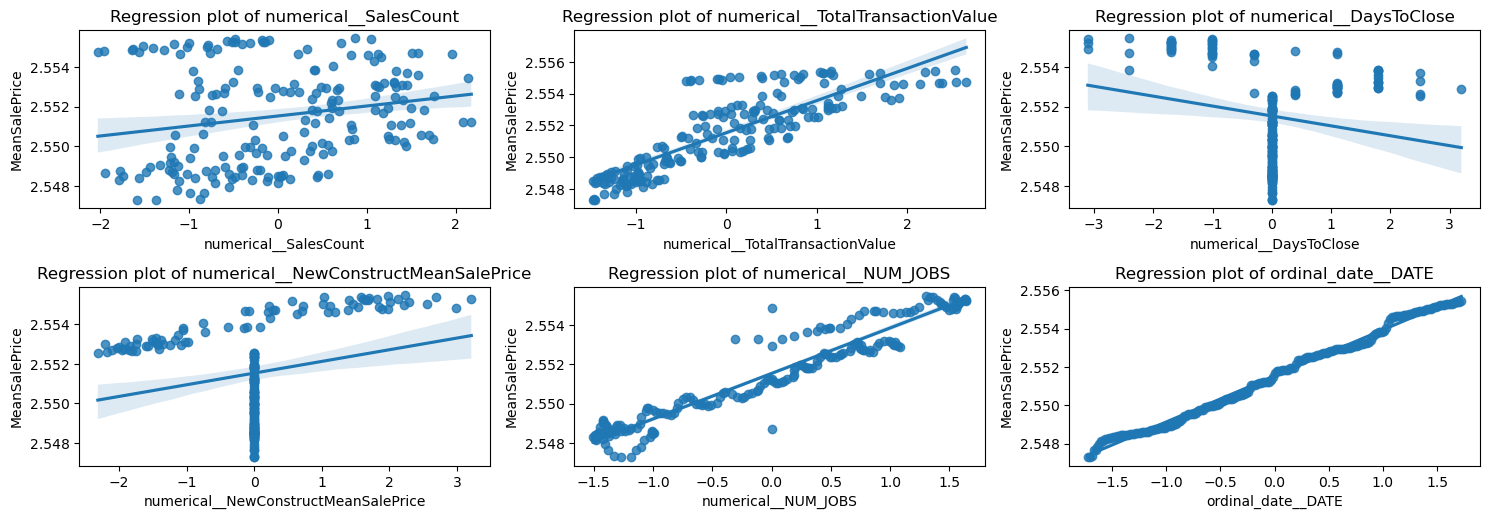

In [90]:
# Plot out the highly correlated features
eda.plot_regression_feature_correlations(corr_min=0.2)

## Perform unsupervised feature selection

Optimal number of features: 11


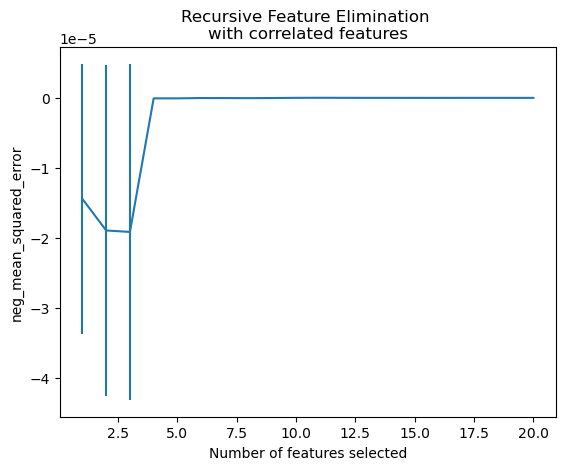

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,selected,ranking,feature_name
0,-1.446627e-05,1.919817e-05,-2.423091e-05,-6.008279e-08,-2.567713e-08,-3.478394e-08,-4.797990e-05,False,3,SalesCount
1,-1.895393e-05,2.364710e-05,-3.983595e-05,-5.622215e-08,-2.579526e-08,-3.127013e-08,-5.482040e-05,True,1,TotalTransactionValue
2,-1.915831e-05,2.394571e-05,-3.957218e-05,-8.348154e-08,-2.564509e-08,-1.083286e-07,-5.600191e-05,False,7,MarketTempIdx
3,-1.208198e-07,8.171272e-08,-2.742788e-07,-8.367302e-08,-3.078733e-08,-1.091197e-07,-1.062400e-07,False,8,DaysToClose
4,-1.215408e-07,1.028688e-07,-3.215172e-07,-5.926304e-08,-3.306086e-08,-9.759201e-08,-9.627104e-08,True,1,DaysOnZillow


In [101]:
# Try recursive feature elimination to find the optimal number of features for a linear regression model
regressor = LinearRegression()
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)
rfecv_results_df.head()

In [102]:
rfe_lr_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE LR Selected Features: {rfe_lr_selected_features}")

RFE LR Selected Features: ['TotalTransactionValue' 'DaysOnZillow' 'ListingPriceCutPct'
 'PctListingsPriceCut' 'PctSoldAboveList' 'PctSoldBelowList'
 'MORTGAGE15US' 'MORTGAGE30US' 'RATE_DIFFERENCE' 'NUM_JOBS' 'DATE']


Optimal number of features: 10


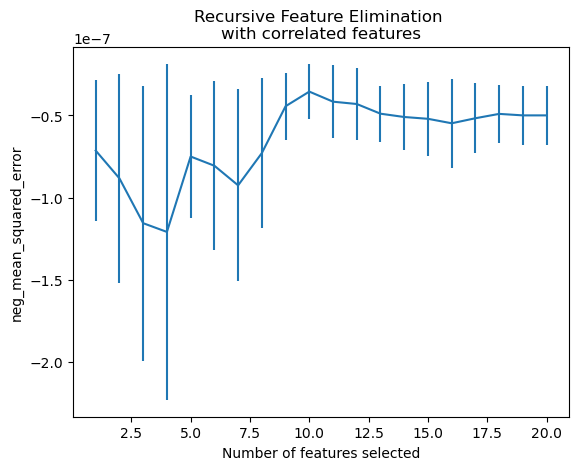

In [103]:
# Try recursive feature elimination to find the optimal number of features for a RidgeCV model
regressor = RidgeCV(alphas=np.logspace(-6, 6, num=5))
rfecv_results_df = eda.perform_unsupervised_regression_rfe_feature_selection(regressor)


In [108]:
rfe_ridge_selected_features = eda.get_rfe_selected_features(rfecv_results_df)
print(f"RFE Ridge Selected features: {rfe_ridge_selected_features}")

RFE Ridge Selected features: ['TotalTransactionValue' 'DaysOnZillow' 'ListingPriceCutPct'
 'PctListingsPriceCut' 'PctSoldAboveList' 'PctSoldBelowList'
 'MORTGAGE15US' 'MORTGAGE30US' 'NUM_JOBS' 'DATE']


In [105]:
# Try using forward SFS (SequentialFeatureSelector) to select the top 28 features
sfs_ridge_selected_features = eda.perform_unsupervised_regression_sfs_feature_selection(n_features=10)
print(f"SFS Ridge Selected Features: {sfs_ridge_selected_features}")


RidgeCV best alpha 0.001
Selected 10 features by forward sequential featureselection in 3.465 seconds
SFS Ridge Selected Features: ['SalesCount', 'DaysOnZillow', 'ListingPriceCutPct', 'NewConstructSalesCount', 'PctSoldBelowList', 'RATE_DIFFERENCE', 'NUM_JOBS', 'GROWTH_PCT', 'DATE', 'CityName']


In [111]:
# Remove colinear features from the list of selected features
# rfe_ridge_selected_features = [rfe_ridge_selected_features]
rfe_ridge_selected_features = list(rfe_ridge_selected_features)
rfe_ridge_selected_features.remove('PctSoldAboveList')
rfe_ridge_selected_features.remove('MORTGAGE15US')
rfe_ridge_selected_features

['TotalTransactionValue',
 'DaysOnZillow',
 'ListingPriceCutPct',
 'PctListingsPriceCut',
 'PctSoldBelowList',
 'MORTGAGE30US',
 'NUM_JOBS',
 'DATE']

In [113]:
# Update EDA object with selected features from RFE
eda.selected_feature_list = rfe_ridge_selected_features

# Now get the list of selected ordinal columns
final_ordinal_cols = eda.get_final_ordinal_col_names(rfe_lr_selected_features)
len(final_ordinal_cols), final_ordinal_cols

(1, ['DATE'])

## Perform final EDA with selected features and ordinal columns

In [114]:
# Reset transformer properties to use the selected columns and ordinal columns
eda.ordinal_encoding_col_dict = {}
for col_name in final_ordinal_cols:
    eda.add_ordinal_encoding_column(col_name, None)

eda.feature_transformer = eda.create_feature_transformer()
eda.feature_transformer

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(memory='named_steps',
                                          steps=[('pruner',
                                                  SimplePruner(infreq=0.95,
                                                               pct_miss=0.8)),
                                                 ('selector',
                                                  SelectedFeaturesTransformer(selected_feature_list=['TotalTransactionValue',
                                                                                                     'DaysOnZillow',
                                                                                                     'ListingPriceCutPct',
                                                                                                     'PctListingsPriceCut',
                                                                                                     'PctSoldBelowList',
                                                                                                     'MORTGAGE30US',
                                                                                                     'NUM_JOBS',
                                                                                                     'DATE'])),
                                                 ('imputer', SimpleI...
                                                                              '2010-01-31',
                                                                              '2008-09-30',
                                                                              '2010-03-31',
                                                                              '2011-03-31',
                                                                              '2010-02-28',
                                                                              '2010-04-30',
                                                                              '2009-09-30',
                                                                              '2008-05-31',
                                                                              '2011-04-30',
                                                                              '2009-07-31',
                                                                              '2011-02-28',
                                                                              '2008-04-30',
                                                                              '2010-05-31',
                                                                              '2008-06-30',
                                                                              '2009-08-31',
                                                                              '2008-08-31',
                                                                              '2008-07-31',
                                                                              '2011-05-31', ...]],
                                                                 encoded_missing_value=-2,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('scaler', StandardScaler())]),
                                 ['DATE'])])

In [115]:
# Check feature analysis to ensure we have no multicollinearity (ie. no infinite vifs)
feature_analysis_df = eda.get_regression_feature_analysis_df()
feature_analysis_df.head()

Best RidgeCV alpha: 1e-06 (R^2 score:  1.00)


,correlation_abs,coefficient_abs,pval,vif,PCA1_abs,PCA2_abs,total
ordinal_date__DATE,0.996436,0.002090,0.210123,14.474358,0.256018,0.534230,1.788774
numerical__NUM_JOBS,0.954660,0.000157,0.954832,13.068360,0.201056,0.563570,1.719444
numerical__TotalTransactionValue,0.838063,0.000195,0.950792,8.382517,0.383366,0.388607,1.610232
numerical__PctSoldBelowList,0.095451,0.000122,0.908569,31.325212,0.484682,0.233860,0.814116
numerical__DaysOnZillow,0.072127,0.000048,0.892728,16.745793,0.456604,0.211226,0.740005


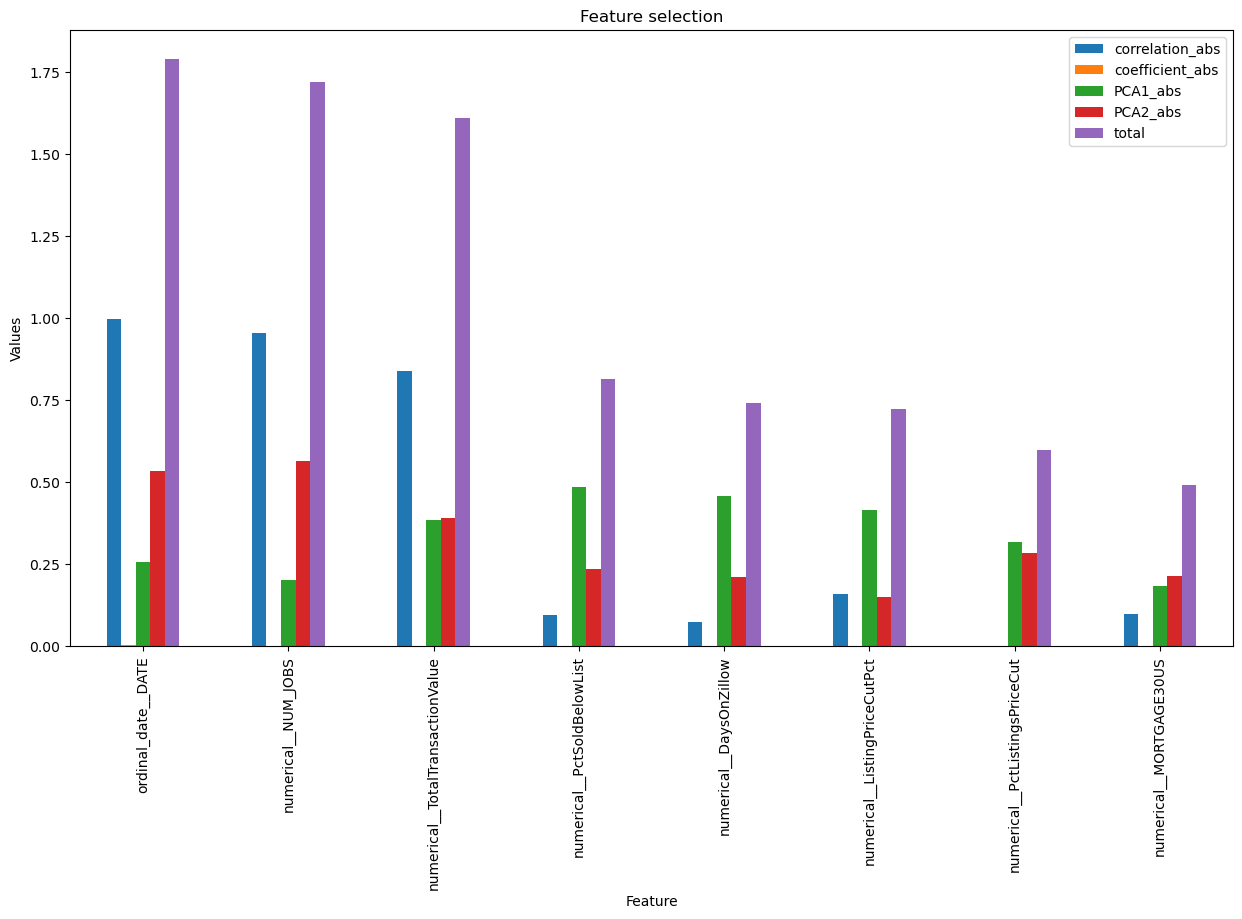

In [116]:
eda.plot_important_features(feature_analysis_df)

# Now do model analysis for multiple regression models

In [117]:
# Reload the data just to be safe
train_full_df = pd.read_csv(denver_file_path)

# Create an instance of RegressorMultiModelEvaluator and set various properties
reg = RegressorMultiModelEvaluator(train_full_df, target_column=target_col)
reg.set_column_transformer_properties(selected_feature_list=eda.selected_feature_list, ordinal_feature_list=final_ordinal_cols)
reg.set_target_column_transformer(eda.target_transformer)

In [118]:
# Create a dict of models to test
model_dict: dict[str, RegressorMixin] = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0, random_state=42),
    'LassoCV': LassoCV(),
    'ElasticNetCV': ElasticNetCV(),
    'RidgeCV': RidgeCV(alphas=np.logspace(-6, 6, num=7)),
    'HistGradientBoost': HistGradientBoostingRegressor(max_iter=200, random_state=42)
}

In [119]:
# Evaluate the models
eval_df = reg.evaluate_models(model_dict)
eval_df

Number original X cols: 25
Number scaled X cols: 8


,train_r2,mse,r2,r2_adj,lr_cv_mean,lr_cv_std,time,y_pred
model_name,,,,,,,,
HistGradientBoost,0.998410,2.250741e-08,0.995916,0.994827,0.991069,0.004267,0.397030,"[2.552913162429354, 2.548636707618142, 2.55382..."
Ridge Regression,0.995909,3.124226e-08,0.994331,0.992819,0.991069,0.004267,0.022034,"[2.552927454239785, 2.5485254556003376, 2.5540..."
Linear Regression,0.996193,3.243271e-08,0.994115,0.992545,0.991069,0.004267,0.061150,"[2.5528824087759188, 2.548531198687603, 2.5540..."
RidgeCV,0.996193,3.243278e-08,0.994115,0.992545,0.991069,0.004267,0.024262,"[2.5528824089236903, 2.5485311978396044, 2.554..."
ElasticNetCV,0.996151,3.330167e-08,0.993957,0.992345,0.991069,0.004267,0.155947,"[2.552903638375998, 2.548521290862036, 2.55408..."
LassoCV,0.996151,3.330299e-08,0.993957,0.992345,0.991069,0.004267,0.166760,"[2.552903620547811, 2.5485212929854857, 2.5540..."


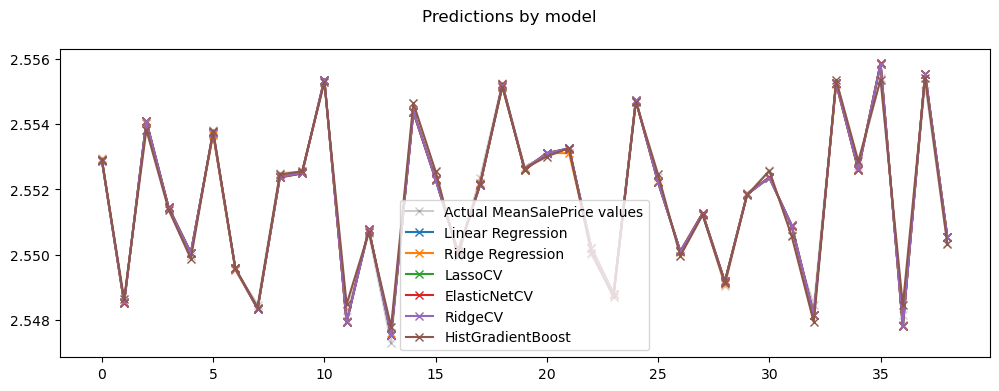

In [120]:
reg.plot_model_evaluations()

In [124]:
# Get the best model
reg.best_model_name

'HistGradientBoost'

## Now use the best model to predict on the test data

In [126]:
# Load test data from a different city
atlanta_file_path = '../../Data/Clean/combined/Atlanta_combined.csv'
test_full_df = pd.read_csv(atlanta_file_path)
test_full_df.head()

,DATE,MeanSalePrice,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,200954.0,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,203419.0,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,205746.0,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,205553.0,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,202855.0,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [127]:
# Drop target column
atlanta_actual_values = test_full_df[target_col]
test_full_df = test_full_df.drop(columns=[target_col])
test_full_df.head()

,DATE,SalesCount,TotalTransactionValue,HomeValueIndex,HomeValueIndexSmSa,MarketTempIdx,DaysToClose,DaysOnZillow,ListingPriceCutAmt,ListingPriceCutPct,...,PctSoldBelowList,MORTGAGE15US,MORTGAGE30US,RATE_DIFFERENCE,NUM_JOBS,GROWTH_PCT,People25PlusThousands_2019,PctHighSchoolDiploma_2019,PctBachelorsDegree_2019,CityName
0,2008-04-30,6463.0,1.235943e+09,185168.707578,189442.061550,NaN,NaN,NaN,NaN,NaN,...,NaN,5.465,5.918,0.452,2454.9,-3.5,4414.04779,89.810682,41.859123,"ATLANTA, GA"
1,2008-05-31,6729.0,1.317605e+09,185331.245765,188426.220342,NaN,NaN,NaN,NaN,NaN,...,NaN,5.600,6.036,0.436,2450.9,-6.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"
2,2008-06-30,7047.0,1.388670e+09,185185.095114,187437.288971,NaN,NaN,NaN,NaN,NaN,...,NaN,5.910,6.320,0.410,2442.4,-6.1,4414.04779,89.810682,41.859123,"ATLANTA, GA"
3,2008-07-31,7086.0,1.429205e+09,184692.089305,186253.861325,NaN,NaN,NaN,NaN,NaN,...,NaN,5.972,6.426,0.454,2434.6,-6.8,4414.04779,89.810682,41.859123,"ATLANTA, GA"
4,2008-08-31,6383.0,1.388101e+09,183376.364934,184882.815462,NaN,NaN,NaN,NaN,NaN,...,NaN,6.025,6.478,0.452,2429.3,-7.2,4414.04779,89.810682,41.859123,"ATLANTA, GA"


In [128]:
# Make predictions with HistGradientBoost
#reg.best_model = model_dict['Linear Regression']
lr_predictions = reg.predict(test_full_df)
lr_predictions

array([241506.47376453, 241506.47376453, 246831.23931787, 249677.72837531,
       248973.26976424, 241506.47376453, 238514.80505304, 237812.72731747,
       228260.63067792, 224329.98603346, 223980.98766433, 224153.14095868,
       232591.02029102, 240628.88855714, 240677.82349467, 240677.82349467,
       248809.57865371, 240868.06314062, 245177.45698066, 245646.00230203,
       245699.64539673, 227840.77710976, 236210.51454422, 236210.51454422,
       238988.28548727, 245123.97219938, 256211.89854849, 263395.78317392,
       268236.5141149 , 266627.47693257, 268843.29859498, 261736.48395541,
       256056.40343792, 249308.94207604, 234106.4488921 , 234438.31430285,
       234438.31430285, 247316.82131243, 253119.49508437, 257603.22729375,
       257425.61317096, 254005.50473545, 250248.30916645, 250415.44725698,
       251798.06121682, 250759.46285839, 252045.76773256, 255634.1365276 ,
       259901.85521972, 270147.9099866 , 280130.05383014, 286199.85959606,
       286857.98324111, 2

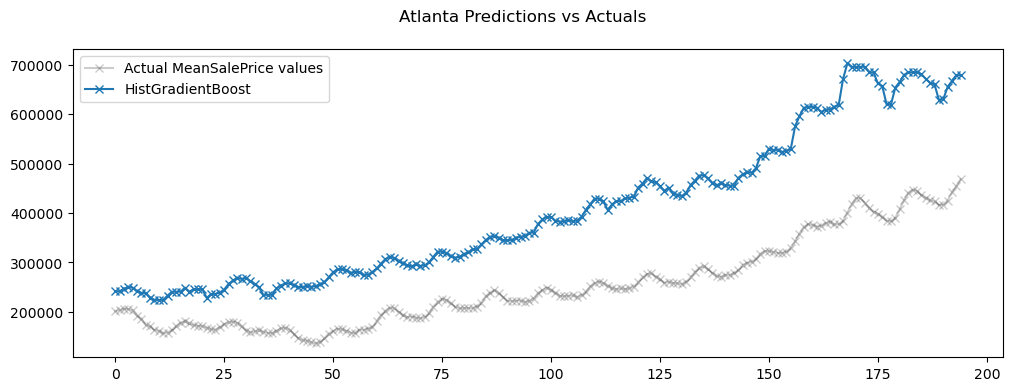

In [129]:
# Plot Actual vs Predictions
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Atlanta Predictions vs Actuals")
ax.plot(
    atlanta_actual_values,
    "x-",
    alpha=0.2,
    label=f"Actual {target_col} values",
    color="black",
)
ax.plot(lr_predictions, "x-", label="HistGradientBoost")
_ = ax.legend()